# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"><img src="https://github.com/logicalclocks/hopsworks-tutorials/blob/master/images/icon102.png?raw=1" width="38px"></img> **Hopsworks Feature Store** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 03: Batch Inference</span>


### <span style='color:#ff5f27'> 📝 Imports

In [1]:
!pip install -U hopsworks --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.8/244.8 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 8.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [2]:
import joblib
from xgboost import plot_importance
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## <span style="color:#ff5f27;"> 📡 Connecting to Hopsworks Feature Store </span>

In [4]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.
Copy your Api Key (first register/login): https://c.app.hopsworks.ai/account/api/generated

Paste it here: ··········
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/630932
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [5]:
# Retrieve the churn_feature_view
feature_view = fs.get_feature_view(
        name = 'churn_feature_view',
        version = 1,
)

## <span style="color:#ff5f27;">🗄 Model Registry</span>


In [6]:
# Get the model registry
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


---

## <span style='color:#ff5f27'>🚀 Fetch and test the model</span>

To identify customers at risk of churn lets retrieve your churn prediction model from Hopsworks model registry.

In [7]:
# Retrieve the model from the model registry
retrieved_model = mr.get_model(
    name="churnmodel",
    version=1,
)

# Download the saved model files to a local directory
saved_model_dir = retrieved_model.download()

In [8]:
# Load the saved XGBoost model using joblib from the downloaded model directory
retrieved_xgboost_model = joblib.load(saved_model_dir + "/churnmodel.pkl")

# Display the retrieved XGBoost model
retrieved_xgboost_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

---
## <span style="color:#ff5f27;">🔮  Use trained model to identify customers at risk of churn </span>


In [9]:
def transform_preds(predictions):
    # Transform numeric predictions to human-readable labels
    return [
        'Churn'
        if pred == 1
        else 'Not Churn'
        for pred
        in predictions
    ]

In [10]:
# Initialize batch scoring
feature_view.init_batch_scoring(1)

# Get the batch data
batch_data = feature_view.get_batch_data()

# Display the first three rows of the batch_data
batch_data.head(3)

Finished: Reading data from Hopsworks, using ArrowFlight (3.28s) 


,contract,tenure,paymentmethod,paperlessbilling,monthlycharges,totalcharges,gender,seniorcitizen,dependents,partner,customerid,deviceprotection,onlinebackup,onlinesecurity,internetservice,multiplelines,phoneservice,techsupport,streamingmovies,streamingtv
0,0,0.819444,0,0,0.711443,0.633835,0,1,0,0,6917-YACBP,0,0,0,0,0,0,0,0,0
1,0,0.013889,0,0,0.749254,0.010787,1,1,0,0,9497-QCMMS,1,1,1,0,0,0,0,1,1
2,0,0.527778,1,0,0.632836,0.362262,1,0,1,0,2240-HSJQD,1,0,1,0,0,0,0,0,0


Let's predict the all for all customer data and then visualize predictions.

In [11]:
# Drop the 'customerid' column from the batch data
batch_data.drop('customerid', axis=1, inplace=True)

# Use the retrieved XGBoost model to make predictions on the batch data
predictions = retrieved_xgboost_model.predict(batch_data)

# Transform numeric predictions to human-readable labels
predictions = transform_preds(predictions)

# Display the first five predictions
predictions[:5]

['Not Churn', 'Churn', 'Not Churn', 'Not Churn', 'Churn']

---
## <span style="color:#ff5f27;">👨🏻‍🎨 Prediction Visualisation</span>

Now you got your predictions but you also would like to exlain predictions to make informed decisions. Lets visualise them and explain important features that influences on the risk of churning.

In [12]:
import inspect

# Recall that you applied transformation functions, such as min max scaler and laber encoder.
# Now you want to transform them back to human readable format.
df_all = batch_data.copy()
td_transformation_functions = feature_view._batch_scoring_server._transformation_functions
for feature_name in td_transformation_functions:
    td_transformation_function = td_transformation_functions[feature_name]
    sig, foobar_locals = inspect.signature(td_transformation_function.transformation_fn), locals()
    param_dict = dict([(param.name, param.default) for param in sig.parameters.values() if param.default != inspect._empty])
    if td_transformation_function.name == "label_encoder":
        rev_dict = {v: k for k, v in param_dict["value_to_index"].items()}
        df_all[feature_name] = df_all[feature_name].map(lambda x: rev_dict[x])
    if td_transformation_function.name == "min_max_scaler":
        df_all[feature_name] = df_all[feature_name].map(lambda x: x*(param_dict["max_value"]-param_dict["min_value"])+param_dict["min_value"])


df_all = df_all
df_all['Churn'] = predictions
df_all.head()

,contract,tenure,paymentmethod,paperlessbilling,monthlycharges,totalcharges,gender,seniorcitizen,dependents,partner,deviceprotection,onlinebackup,onlinesecurity,internetservice,multiplelines,phoneservice,techsupport,streamingmovies,streamingtv,Churn
0,Month-to-month,59.0,Electronic check,Yes,89.75,5496.90,Female,1,No,No,Yes,Yes,Yes,Fiber optic,Yes,Yes,No,No,No,Not Churn
1,Month-to-month,1.0,Electronic check,Yes,93.55,93.55,Male,1,No,No,No,No,No,Fiber optic,Yes,Yes,No,Yes,Yes,Churn
2,Month-to-month,38.0,Mailed check,Yes,81.85,3141.70,Male,0,Yes,No,No,Yes,No,Fiber optic,Yes,Yes,No,No,No,Not Churn
3,Two year,64.0,Bank transfer (automatic),No,110.30,6997.30,Female,0,Yes,Yes,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Not Churn
4,Month-to-month,24.0,Bank transfer (automatic),Yes,49.55,1210.40,Male,0,No,No,No,No,Yes,DSL,No,Yes,No,No,No,Churn


Lets plot feature importance

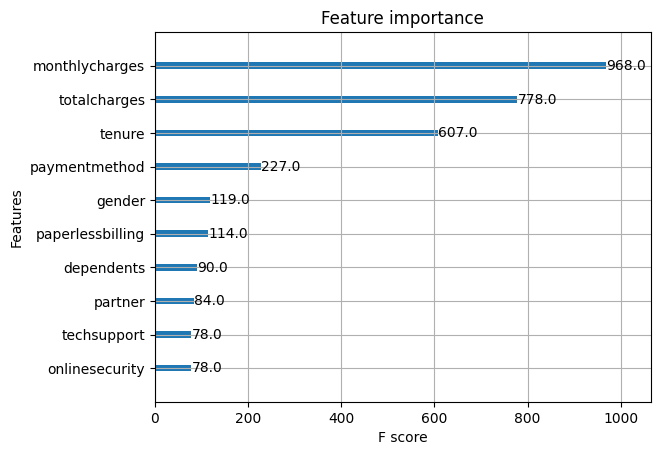

In [13]:
# Plot feature importance using XGBoost's plot_importance function
figure_imp = plot_importance(
    retrieved_xgboost_model,  # The retrieved XGBoost model
    max_num_features=10,      # Maximum number of features to display
    importance_type='weight', # Type of importance to display ('weight' represents the number of times a feature appears in a tree across all trees)
)

# Show the plot
plt.show()

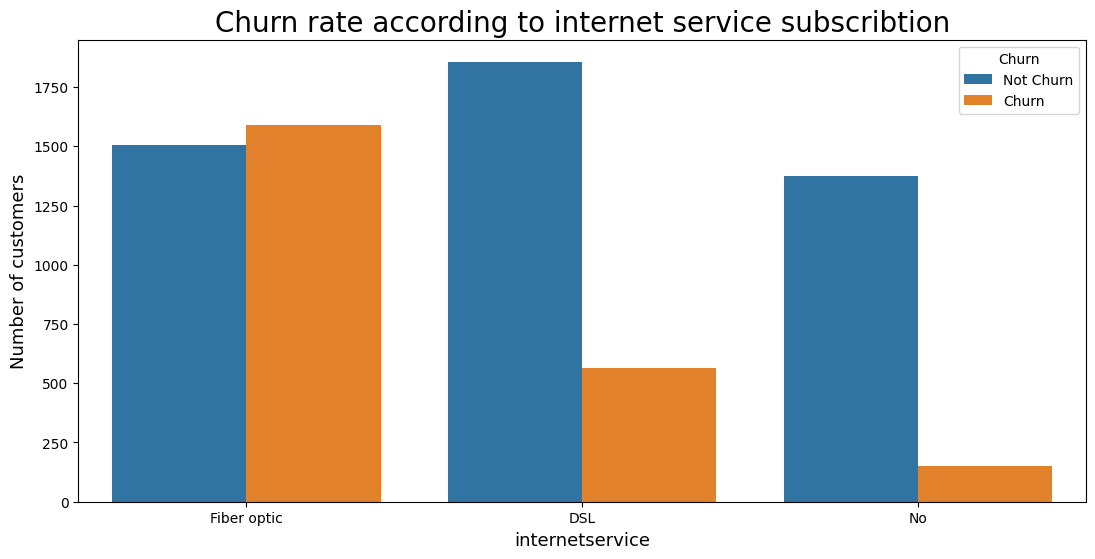

In [14]:
plt.figure(figsize = (13,6))

sns.countplot(
    data=df_all,
    x='internetservice',
    hue='Churn',
)

plt.title('Churn rate according to internet service subscribtion', fontsize=20)
plt.xlabel("internetservice", fontsize=13)
plt.ylabel('Number of customers', fontsize=13)

plt.show()

Lets visualise couple of more imporant features such as `streamingtv` and `streamingmovies`

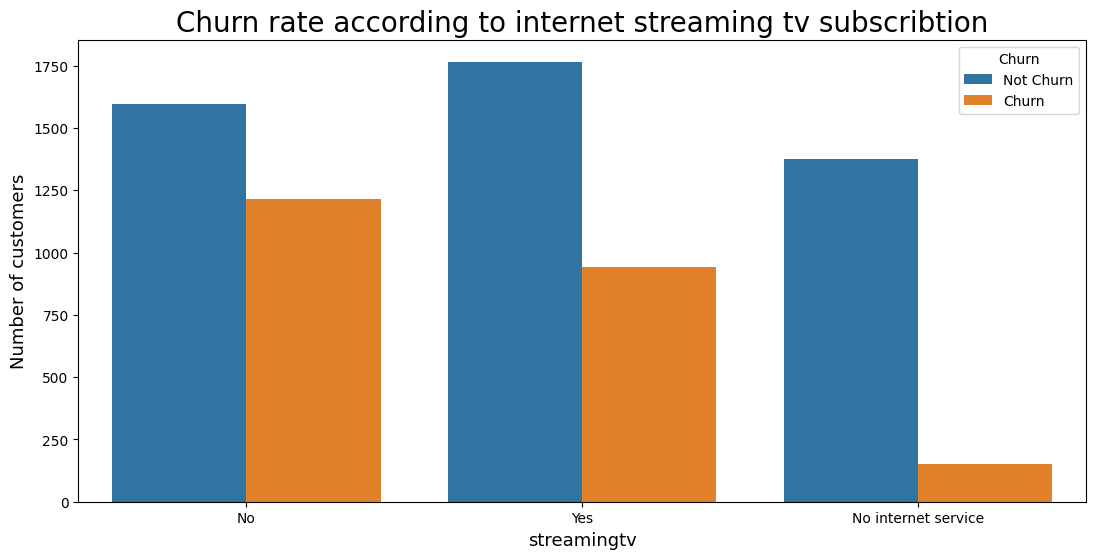

In [15]:
plt.figure(figsize = (13,6))

sns.countplot(
    data=df_all,
    x='streamingtv',
    hue='Churn',
)

plt.title('Churn rate according to internet streaming tv subscribtion', fontsize=20)
plt.xlabel("streamingtv", fontsize=13)
plt.ylabel('Number of customers', fontsize=13)

plt.show()

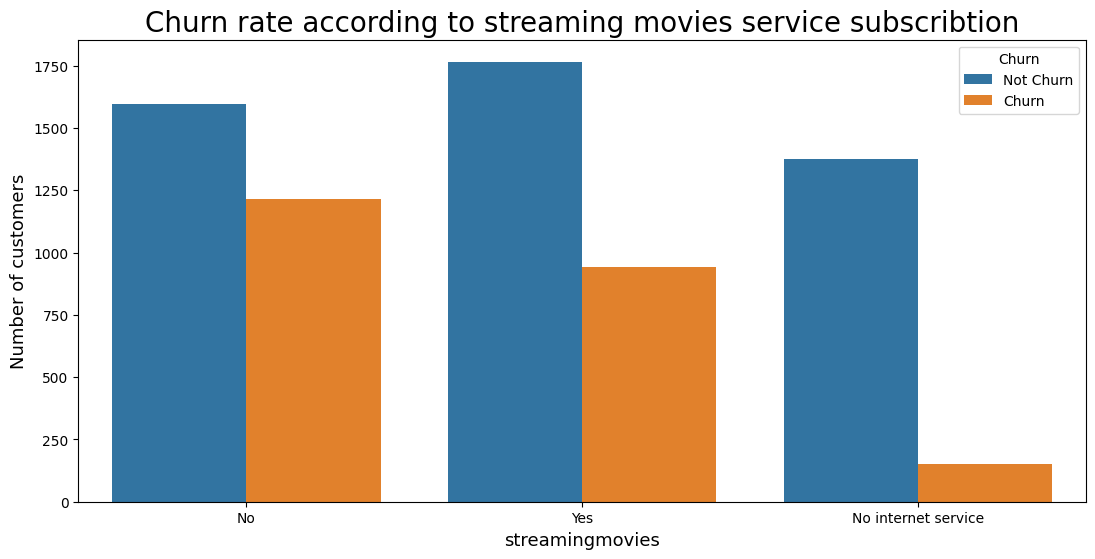

In [16]:
plt.figure(figsize = (13,6))

sns.countplot(
    data=df_all,
    x='streamingtv',
    hue='Churn',
)

plt.title('Churn rate according to streaming movies service subscribtion', fontsize=20)
plt.xlabel("streamingmovies", fontsize=13)
plt.ylabel('Number of customers', fontsize=13)

plt.show()

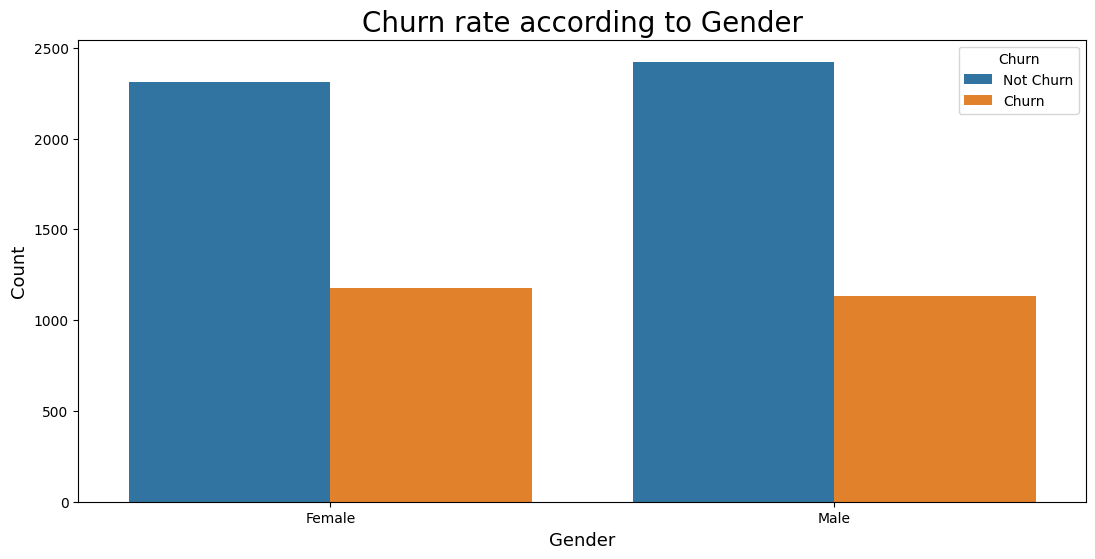

In [17]:
plt.figure(figsize = (13,6))

sns.countplot(
    data=df_all,
    x='gender',
    hue='Churn',
)

plt.title('Churn rate according to Gender', fontsize=20)
plt.xlabel("Gender", fontsize=13)
plt.ylabel('Count', fontsize=13)

plt.show()

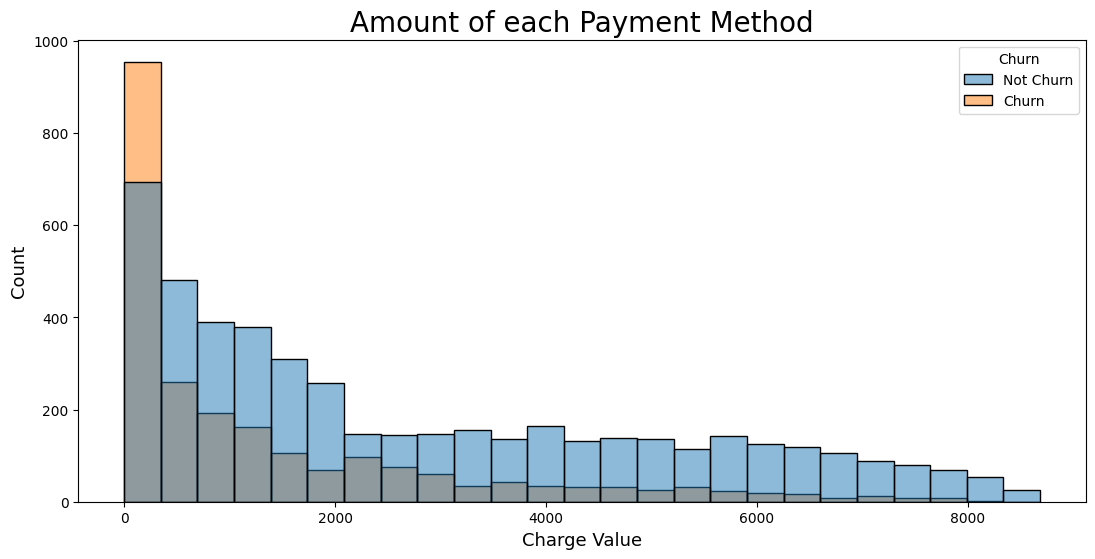

In [18]:
plt.figure(figsize = (13,6))

sns.histplot(
    data=df_all,
    x='totalcharges',
    hue='Churn',
)

plt.title('Amount of each Payment Method', fontsize=20)
plt.xlabel("Charge Value", fontsize=13)
plt.ylabel('Count', fontsize=13)

plt.show()

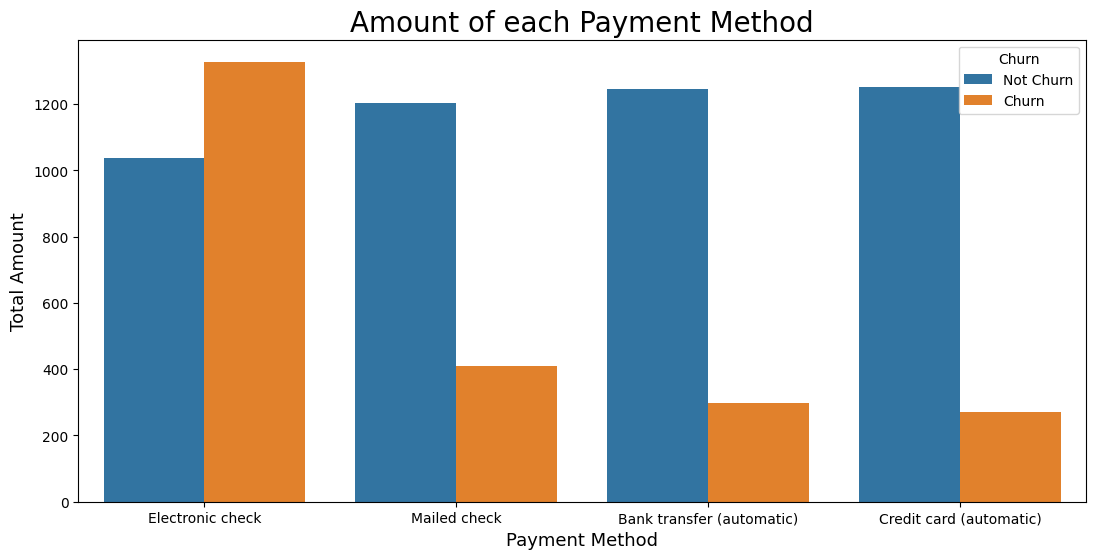

In [19]:
plt.figure(figsize = (13,6))

sns.countplot(
    data=df_all,
    x='paymentmethod',
    hue='Churn',
)

plt.title('Amount of each Payment Method', fontsize=20)
plt.xlabel("Payment Method", fontsize=13)
plt.ylabel('Total Amount', fontsize=13)

plt.show()

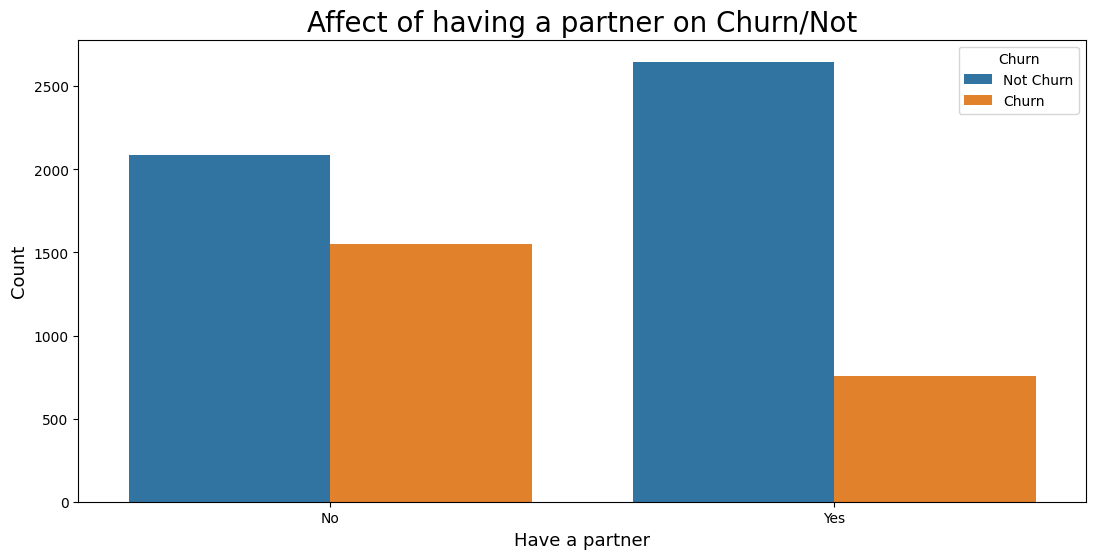

In [20]:
plt.figure(figsize = (13,6))

sns.countplot(
    data=df_all,
    x='partner',
    hue='Churn',
)

plt.title('Affect of having a partner on Churn/Not', fontsize=20)
plt.xlabel("Have a partner", fontsize=13)
plt.ylabel('Count', fontsize=13)

plt.show()

---
## <span style="color:#ff5f27;">🧑🏻‍🔬 StreamLit App </span>

If you want to use an **interactive dashboards** - you can use a StreamLit App.

Use the following commands in terminal to run a Streamlit App:

> `cd {%path_to_hopsworks_tutorials%}/`  </br>
> `conda activate ./miniconda/envs/hopsworks` </br>
> `python -m streamlit run churn/streamlit_app.py`</br>

**⚠️** If you are running on Colab, you will need to follow a different procedure. As highlighted in this [notebook](https://colab.research.google.com/github/mrm8488/shared_colab_notebooks/blob/master/Create_streamlit_app.ipynb).

---
## <span style="color:#ff5f27;"> 👓  Exploration</span>
In the Hopsworks feature store, the metadata allows for multiple levels of explorations and review. Here we will show a few of those capacities.

### <span style="color:#ff5f27;">🔎 <b>Search</b></span>
Using the search function in the ui, you can query any aspect of the feature groups, feature_view and training data that was previously created.

### <span style="color:#ff5f27;">📊 <b>Statistics</b> </span>
We can also enable statistics in one or all the feature groups.

In [21]:
customer_info_fg = fs.get_feature_group("customer_info", version = 1)
customer_info_fg.statistics_config = {
    "enabled": True,
    "histograms": True,
    "correlations": True,
}

customer_info_fg.update_statistics_config()
customer_info_fg.compute_statistics()

Statistics Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/630932/jobs/named/customer_info_1_compute_stats_13042024104345/executions


![fg-statistics](https://github.com/logicalclocks/hopsworks-tutorials/blob/master/churn/images/churn_statistics.gif?raw=1)


### <span style="color:#ff5f27;">⛓️ <b> Lineage </b> </span>
In all the feature groups and feature view you can look at the relation between each abstractions; what feature group created which training dataset and that is used in which model.
This allows for a clear undestanding of the pipeline in relation to each element.

---

### <span style="color:#ff5f27;">🥳 <b> Next Steps  </b> </span>
Congratulations you've now completed the churn risk prediction tutorial for Managed Hopsworks.

Check out our other tutorials on ➡ https://github.com/logicalclocks/hopsworks-tutorials

Or documentation at ➡ https://docs.hopsworks.ai